In [306]:
import numpy as np
import qutip as qt

import numpy as np
from qutip import Options
import qutip as qt
from qutip import ket2dm
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm
import cmath

In [435]:
qubit_dim = 2

w1_un = 4
w2_un = 6
w3_un = 4.2
ws_un = 5.6666666666666666


qubit1 = QubitMode(
    name="q1", dim=2, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    name="q2", dim=2, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    name="q3", dim=2, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875,
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

In [436]:
# simulating the non time-dependent terms along with the snail qubit terms
#declare all the elements needed for the hamiltonian 

all_freq = [w1_un,w2_un,w3_un]

g1 = .1 * np.abs(ws_un - w1_un)
g2 = .1 * np.abs(ws_un - w2_un)
g3 = .1 * np.abs(ws_un - w3_un)

#snail dimensions
sd = 1


#all of the following coefficients are the same 
l1 = g1/np.abs(ws_un-w1_un)
l2 = g2/np.abs(ws_un-w2_un)
l3 = g3/np.abs(ws_un-w3_un)

# w1 = w1_un + (g1/(w1_un-ws_un))*g1
# w2 = w2_un + (g2/(w2_un-ws_un))*g2
# w3 = w3_un + (g3/(w3_un-ws_un))*g3
# ws = ws_un + (g2/(ws_un-w2_un))*g2 + (g3/(ws_un-w3_un))*g3 + (g1/(ws_un-w1_un))*g1

w1 = w1_un 
w2 = w2_un 
w3 = w3_un 
ws = ws_un 

T = 100


#pump frequency 
wp = w1-w2

# Amp = 7
# eta = np.pi/(12*(10**-9))* Amp
eta = 1

#time independent hamiltonian 
# H_no_time = 6*(l1**2)*eta*(qt.tensor(qubit1.a,qubit2.a_dag,qt.qeye(2),qt.qeye(sd)) + qt.tensor(qubit1.a_dag,qubit2.a,qt.qeye(2),qt.qeye(sd)))
H_no_time = 6*(l1**2)*eta*(qs.modes_a[qubit1]*qs.modes_a_dag[qubit2] + qs.modes_a[qubit2]*qs.modes_a_dag[qubit1])

#create the individual time dependent hamiltonian(operators only)

# try the operators that evan has 
qubit1_qubit2_adj_H = 6*(l1**2)*eta*qs.modes_a[qubit1]*qs.modes_a_dag[qubit2]
qubit1_adj_qubit2_H = 6*(l1**2)*eta*qs.modes_a[qubit2]*qs.modes_a_dag[qubit1]
snail_qubit1_H = 6*(l1)*eta*qs.modes_a[snail]*qs.modes_a_dag[qubit1]
snail_qubit3_H = 6*(l1)*eta*qs.modes_a[snail]*qs.modes_a_dag[qubit3]
snail_adj_qubit1_H = 6*(l1)*eta*qs.modes_a[qubit1]*qs.modes_a_dag[snail]
snail_ajd_qubit3_H = 6*(l1)*eta*qs.modes_a[qubit3]*qs.modes_a_dag[snail]

#added for extra analysis 
snail_qubit2_H = 6*(l1**2)*eta*qs.modes_a[snail]*qs.modes_a_dag[qubit2]
snail_ajd_qubit2_H = 6*(l1**2)*eta*qs.modes_a[qubit2]*qs.modes_a_dag[snail]

#create the time coefficients of all of these hamiltonian parts 
#write in the evaluated functions and find the values before multiplying to a matrix
def int_func(w1,w2,wp,t):
    a=((np.exp(-1j*(w1-w2+wp)*t))/(-1j*(w1-w2+wp)) - (1/(-1j*(w1-w2+wp))))
    return a

def int_func_conj_wp(w1,w2,wp,t):
     a = ((np.exp(-1j*(w1-w2-wp)*t))/(-1j*(w1-w2-wp)) - (1/(-1j*(w1-w2-wp))))
     return a

def int_func_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2+wp)*t))/(1j*(w1-w2+wp)) - (1/(1j*(w1-w2+wp))))
    return a 

def int_func_conj_wp_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2-wp)*t))/(1j*(w1-w2-wp)) - (1/(1j*(w1-w2-wp))))
    return a


qubit1_qubit2_adj_val = int_func(w1,w2,wp,T)
qubit1_adj_qubit2_val = int_func_conj(w1,w2,wp,T)
snail_qubit1_val = int_func(ws,w1,wp,T) + int_func_conj_wp(ws,w1,wp,T)
snail_qubit3_val = int_func(ws,w3,wp,T) + int_func_conj_wp(ws,w3,wp,T)
snail_adj_qubit1_val = int_func(w1,ws,wp,T) + int_func_conj_wp(w1,ws,wp,T)
snail_ajd_qubit3_val = int_func(w3,ws,wp,T) + int_func_conj_wp(w3,ws,wp,T)

#added for specific analysis 
snail_qubit2_val = int_func(ws,w2,wp,T) + int_func_conj_wp(ws,w2,wp,T)
snail_ajd_qubit2_val = int_func(w2,ws,wp,T) + int_func_conj_wp(w2,ws,wp,T)


# creation of the hamiltonian based on the integrals and the operators

H = [H_no_time, qubit1_qubit2_adj_H, qubit1_adj_qubit2_H, snail_qubit1_H, snail_qubit3_H, snail_adj_qubit1_H, snail_ajd_qubit3_H,
     snail_qubit2_H, snail_ajd_qubit2_H]
time_multiplier = [T, qubit1_qubit2_adj_val, qubit1_adj_qubit2_val, snail_qubit1_val, snail_qubit3_val, snail_adj_qubit1_val, 
                   snail_ajd_qubit3_val, snail_qubit2_val, snail_ajd_qubit2_val]


#W = H*T part of the exponential

W = []
for i in range(len(H)):
    W.append(H[i] * time_multiplier[i])

W = W[0] + W[1] + W[2] + W[3] + W[4] + W[5] + W[6] + W[7] + W[8]


U_propagator = (-1j * W).expm()



In [437]:
# creating the initial state
psi0 = qs.prepare_tensor_fock_state([(qubit2, 1)])
rho0 = qt.ket2dm(psi0)

In [438]:
# #create the target iswap gate
# U_targ = U = qt.tensor(qt.qip.operations.iswap(N=2),qt.qeye(2),qt.identity(cavity.dim))
desired_U = qt.qip.operations.iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
for mode in qs.modes[2:]:  # Skip the first two qubits as they're already included
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2


expected_rho = qt.Qobj(desired_U * rho0 * desired_U.dag())

In [439]:
np.abs(qt.average_gate_fidelity(desired_U, U_propagator))

0.06887993589774115

In [440]:
#optimize over the amplitude to find the highest fidelity 
amps = np.linspace(0,8,1000)
fid = []
Z=[]

for i in amps:
    for j in range(len(H)):
        Z.append(i * H[j] * time_multiplier[j])

    W = Z[0] + Z[1] + Z[2] + Z[3] + Z[4] + Z[5] + Z[6] + Z[7] + Z[8]

    U_propagator = (-1j * W).expm()

    #calculate the fidelity
    fid.append(np.abs(qt.average_gate_fidelity(desired_U, U_propagator)))

    #clearing the list for the next iteration
    Z.clear()

In [441]:
#finding the max fidelity that was found 
max_fid = 0.0
for i in range(len(fid)):
    if max_fid < fid[i]:
        max_fid = fid[i]
        location = i

amplitude = location*(8/1000)
print("The max fidelity is = %s and the amplitude is = %s" % (max_fid, amplitude))

The max fidelity is = 0.25925925925925924 and the amplitude is = 0.0


In [442]:
#declare all the elements needed for the hamiltonian that contains only the qubits 
eta = 1
# try the operators that evan has 
qubit1_qubit2_adj_H = 6*(l1**2)*eta*qs.modes_a[qubit1]*qs.modes_a_dag[qubit2]
qubit1_adj_qubit2_H = 6*(l1**2)*eta*qs.modes_a[qubit2]*qs.modes_a_dag[qubit1]
qubit1_qubit3_adj_H = 6*(l1**2)*eta*qs.modes_a[qubit1]*qs.modes_a_dag[qubit3]
qubit2_qubit3_adj_H = 6*(l1**2)*eta*qs.modes_a[qubit2]*qs.modes_a_dag[qubit3]
qubit1_adj_qubit3_H = 6*(l1**2)*eta*qs.modes_a[qubit3]*qs.modes_a_dag[qubit1]
qubit2_adj_qubit3_H = 6*(l1**2)*eta*qs.modes_a[qubit3]*qs.modes_a_dag[qubit2]


#create the time coefficients of all of these hamiltonian parts 
#write in the evaluated functions and find the values before multiplying to a matrix
def int_func(w1,w2,wp,t):
    a=((np.exp(-1j*(w1-w2+wp)*t))/(-1j*(w1-w2+wp)) - (1/(-1j*(w1-w2+wp))))
    return a

def int_func_conj_wp(w1,w2,wp,t):
     a = ((np.exp(-1j*(w1-w2-wp)*t))/(-1j*(w1-w2-wp)) - (1/(-1j*(w1-w2-wp))))
     return a

def int_func_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2+wp)*t))/(1j*(w1-w2+wp)) - (1/(1j*(w1-w2+wp))))
    return a 

def int_func_conj_wp_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2-wp)*t))/(1j*(w1-w2-wp)) - (1/(1j*(w1-w2-wp))))
    return a

T = 100

qubit1_qubit2_adj_val = int_func(w1,w2,wp,T)
qubit1_adj_qubit2_val = int_func_conj(w1,w2,wp,T)
qubit1_qubit3_adj_val = int_func(w1,w3,wp,T) + int_func_conj_wp(w1,w3,wp,T)
qubit2_qubit3_adj_val = int_func(w2,w3,wp,T) + int_func_conj_wp(w2,w3,wp,T)
qubit1_adj_qubit3_val = int_func(w3,w1,wp,T) + int_func_conj_wp(w3,w1,wp,T)
qubit2_adj_qubit3_val = int_func(w3,w2,wp,T) + int_func_conj_wp(w3,w2,wp,T)

# creating the hamiltonian matrix and the time multiplier
H = [H_no_time, qubit1_qubit2_adj_H, qubit1_adj_qubit2_H, qubit1_qubit3_adj_H, qubit2_qubit3_adj_H, qubit1_adj_qubit3_H, qubit2_adj_qubit3_H]
time_multiplier = [T, qubit1_qubit2_adj_val, qubit1_adj_qubit2_val, qubit1_qubit3_adj_val, qubit2_qubit3_adj_val, qubit1_adj_qubit3_val, qubit2_adj_qubit3_val]


#W = H*T part of the exponential

W = []
for i in range(len(H)):
    W.append(7.072 * H[i] * time_multiplier[i])

W = W[0] + W[1] + W[2] + W[3] + W[4] + W[5] + W[6]


U_propagator = (-1j * W).expm()

In [443]:
np.abs(qt.average_gate_fidelity(desired_U, U_propagator))

0.9967489177704347

In [444]:
#optimize over the amplitude to find the highest fidelity for H3
amps = np.linspace(0,8,1000)
fid = []
Z=[]

for i in amps:
    for j in range(len(H)):
        Z.append(i * H[j] * time_multiplier[j])

    P = Z[0] + Z[1] + Z[2] + Z[3] + Z[4] + Z[5] + Z[6]

    U_propagator = (-1j * P).expm()

    #calculate the fidelity
    fid.append(np.abs(qt.average_gate_fidelity(desired_U, U_propagator)))

    #clearing the list for the next iteration
    Z.clear()

In [445]:
#finding the max fidelity that was found 
max_fid = 0.0
for i in range(len(fid)):
    if max_fid < fid[i]:
        max_fid = fid[i]
        location = i

amplitude = location * (8 / 1000)
print("The max fidelity is = %s and the amplitude is = %s" % (max_fid, amplitude))

The max fidelity is = 0.9971975832280756 and the amplitude is = 1.832


In [455]:
#optimizing over the amplitude and the frequencies 
amps = np.linspace(0,8,400)
freq = np.linspace(5.5,5.999999999,100)
amps_freq = [(i,j) for i in freq for j in amps]
results = []

#run the for loop that will evaluate all of the fidelities 
for i in range(len(amps_freq)):
    for j in range(len(H)):
        
        qubit1_qubit2_adj_val = int_func(w1,w2,wp,T)
        qubit1_adj_qubit2_val = int_func_conj(w1,w2,wp,T)
        qubit1_qubit3_adj_val = int_func(w1,amps_freq[i][0],wp,T) + int_func_conj_wp(w1,amps_freq[i][0],wp,T)
        qubit2_qubit3_adj_val = int_func(w2,amps_freq[i][0],wp,T) + int_func_conj_wp(w2,amps_freq[i][0],wp,T)
        qubit1_adj_qubit3_val = int_func(amps_freq[i][0],w1,wp,T) + int_func_conj_wp(amps_freq[i][0],w1,wp,T)
        qubit2_adj_qubit3_val = int_func(amps_freq[i][0],w2,wp,T) + int_func_conj_wp(amps_freq[i][0],w2,wp,T)

        time_multiplier = [T, qubit1_qubit2_adj_val, qubit1_adj_qubit2_val, qubit1_qubit3_adj_val, qubit2_qubit3_adj_val, qubit1_adj_qubit3_val, qubit2_adj_qubit3_val]

        Z.append(amps_freq[i][1] * H[j] * time_multiplier[j])

    W = Z[0] + Z[1] + Z[2] + Z[3] + Z[4] + Z[5] + Z[6]

    U_propagator = (-1j * W).expm()

    #calculate the fidelity
    fid = np.abs(qt.average_gate_fidelity(desired_U, U_propagator))
    results.append([amps_freq[i][0],amps_freq[i][1],fid])

    #clearing the list for the next iteration
    Z.clear()


In [456]:
#take the results from the cell above and find what max fidelity at a set frequency is 
#don't really care about the amplitude but needed to sweep over it 
freqs = []
fids = []

for i in range(len(freq)):
    max_fid_freq = 0.0   
    for j in range(len(amps)):
        # want the max fidelity from each frequency 
        if max_fid_freq < results[(400 * i) + j][2]:
            max_fid_freq = results[(400 * i) + j][2]
    #making the set of frequencies and the max fid achieved at said frequency
    freqs.append(results[(400 * i) + j][0])
    fids.append(max_fid_freq)   



Text(0, 0.5, 'Fidelity')

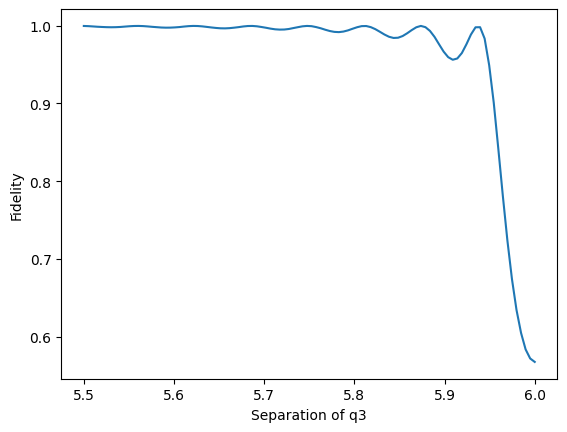

In [457]:
plt.plot(freqs,fids)
plt.xlabel("Separation of q3")
plt.ylabel("Fidelity")

In [355]:
# simulating the whole hamiltonian 
# declare all the elements needed for the hamiltonian that contains only the qubits 


# try the operators that evan has 
qubit1_qubit2_adj_H = 6*(l1**2)*eta*qs.modes_a[qubit1]*qs.modes_a_dag[qubit2]
qubit1_adj_qubit2_H = 6*(l1**2)*eta*qs.modes_a[qubit2]*qs.modes_a_dag[qubit1]
qubit1_qubit3_adj_H = 6*(l1**2)*eta*qs.modes_a[qubit1]*qs.modes_a_dag[qubit3]
qubit2_qubit3_adj_H = 6*(l1**2)*eta*qs.modes_a[qubit2]*qs.modes_a_dag[qubit3]
qubit1_adj_qubit3_H = 6*(l1**2)*eta*qs.modes_a[qubit3]*qs.modes_a_dag[qubit1]
qubit2_adj_qubit3_H = 6*(l1**2)*eta*qs.modes_a[qubit3]*qs.modes_a_dag[qubit2]
snail_qubit1_H = 6*(l1)*eta*qs.modes_a[snail]*qs.modes_a_dag[qubit1]
snail_qubit3_H = 6*(l1)*eta*qs.modes_a[snail]*qs.modes_a_dag[qubit3]
snail_adj_qubit1_H = 6*(l1)*eta*qs.modes_a[qubit1]*qs.modes_a_dag[snail]
snail_ajd_qubit3_H = 6*(l1)*eta*qs.modes_a[qubit3]*qs.modes_a_dag[snail]

#create the time coefficients of all of these hamiltonian parts 

#write in the evaluated functions and find the values before multiplying to a matrix
def int_func(w1,w2,wp,t):
    a=((np.exp(-1j*(w1-w2+wp)*t))/(-1j*(w1-w2+wp)) - (1/(-1j*(w1-w2+wp))))
    return a

def int_func_conj_wp(w1,w2,wp,t):
     a = ((np.exp(-1j*(w1-w2-wp)*t))/(-1j*(w1-w2-wp)) - (1/(-1j*(w1-w2-wp))))
     return a

def int_func_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2+wp)*t))/(1j*(w1-w2+wp)) - (1/(1j*(w1-w2+wp))))
    return a 

def int_func_conj_wp_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2-wp)*t))/(1j*(w1-w2-wp)) - (1/(1j*(w1-w2-wp))))
    return a

T = 100

qubit1_qubit2_adj_val = int_func(w1,w2,wp,T)
qubit1_adj_qubit2_val = int_func_conj(w1,w2,wp,T)
qubit1_qubit3_adj_val = int_func(w1,w3,wp,T) + int_func_conj_wp(w1,w3,wp,T)
qubit2_qubit3_adj_val = int_func(w2,w3,wp,T) + int_func_conj_wp(w2,w3,wp,T)
qubit1_adj_qubit3_val = int_func(w3,w1,wp,T) + int_func_conj_wp(w3,w1,wp,T)
qubit2_adj_qubit3_val = int_func(w3,w2,wp,T) + int_func_conj_wp(w3,w2,wp,T)
snail_qubit1_val = int_func(ws,w1,wp,T) + int_func_conj_wp(ws,w1,wp,T)
snail_qubit3_val = int_func(ws,w3,wp,T) + int_func_conj_wp(ws,w3,wp,T)
snail_adj_qubit1_val = int_func_conj(ws,w1,wp,T) + int_func_conj_wp_conj(ws,w1,wp,T)
snail_ajd_qubit3_val = int_func_conj(ws,w3,wp,T) + int_func_conj_wp_conj(ws,w3,wp,T)

# creating the hamiltonian matrix and the time multiplier
H = [H_no_time, qubit1_qubit2_adj_H, qubit1_adj_qubit2_H, qubit1_qubit3_adj_H, qubit2_qubit3_adj_H,
    qubit1_adj_qubit3_H, qubit2_adj_qubit3_H, snail_qubit1_H, snail_qubit3_H, snail_adj_qubit1_H, snail_ajd_qubit3_H]
time_multiplier = [T, qubit1_qubit2_adj_val, qubit1_adj_qubit2_val, qubit1_qubit3_adj_val, qubit2_qubit3_adj_val, 
                   qubit1_adj_qubit3_val, qubit2_adj_qubit3_val, snail_qubit1_val, snail_qubit3_val, snail_adj_qubit1_val, snail_ajd_qubit3_val]


#W = H*T part of the exponential

W = []
for i in range(len(H)):
    W.append(eta * H[i] * time_multiplier[i])

W = W[0] + W[1] + W[2] + W[3] + W[4] + W[5] + W[6] + W[7] + W[8] + W[9] + W[10] 


U_propagator = (-1j * W).expm()

In [356]:
np.abs(qt.average_gate_fidelity(desired_U, U_propagator))

0.014341254429242714

In [357]:
#optimize over the amplitude to find the highest fidelity for H3
amps = np.linspace(0,8,1000)
fid = []
Z=[]

for i in amps:
    for j in range(len(H)):
        Z.append(i * H[j] * time_multiplier[j])

    W = Z[0] + Z[1] + Z[2] + Z[3] + Z[4] + Z[5] + Z[6] + Z[7] + Z[8] + Z[9] + Z[10] 

    U_propagator = (-1j * W).expm()

    #calculate the fidelity
    fid.append(np.abs(qt.average_gate_fidelity(desired_U, U_propagator)))

    #clearing the list for the next iteration
    Z.clear()

In [358]:
#finding the max fidelity that was found 
max_fid = 0.0
for i in range(len(fid)):
    if max_fid < fid[i]:
        max_fid = fid[i]
        location = i

amplitude = location*(8/1000)
print("The max fidelity is = %s and the amplitude is = %s" % (max_fid, amplitude))

The max fidelity is = 0.25925925925925924 and the amplitude is = 0.0


In [ ]:
# need to actually optimize to find the graph data that you are looking for
# you will have to optimize over the eta(amplitude) while also scanning over the position of the qubits
# you will then have to run code to be able to find the data result that you are looking for because it will have too many unnecessary points
